<a href="https://colab.research.google.com/github/hydmic009/CS3001F-A1/blob/main/Textbook_active2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Establishing Performance Benchmarks ---
Accuracy with full training set (1400 labels): 0.9093
Accuracy with 50 random labels: 0.7582

--- Method 1: Semi-Supervised Learning via Label Propagation ---
Accuracy with 50 representative labels: 0.8388
Accuracy after propagating labels to all 1400 samples: 0.8589

--- Method 2: Active Learning ---
Starting with 50 representative labels and intelligently querying for more.
Query  1 | Added label for index  899 | New Accuracy: 0.8338
Query  2 | Added label for index 1288 | New Accuracy: 0.8388
Query  3 | Added label for index  482 | New Accuracy: 0.8539
Query  4 | Added label for index  792 | New Accuracy: 0.8514
Query  5 | Added label for index 1210 | New Accuracy: 0.8539
Query  6 | Added label for index 1149 | New Accuracy: 0.8338
Query  7 | Added label for index  480 | New Accuracy: 0.8388
Query  8 | Added label for index   37 | New Accuracy: 0.8237
Query  9 | Added label for index  555 | New Accuracy: 0.8237
Query 10 | Added label for i

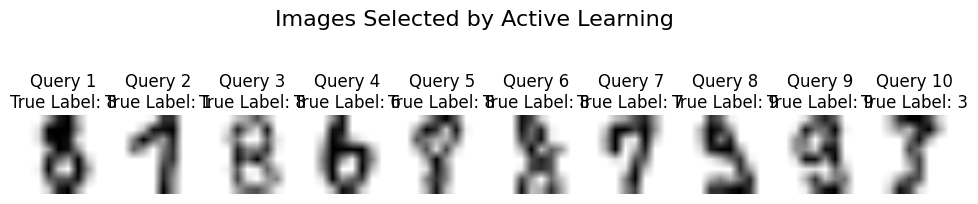

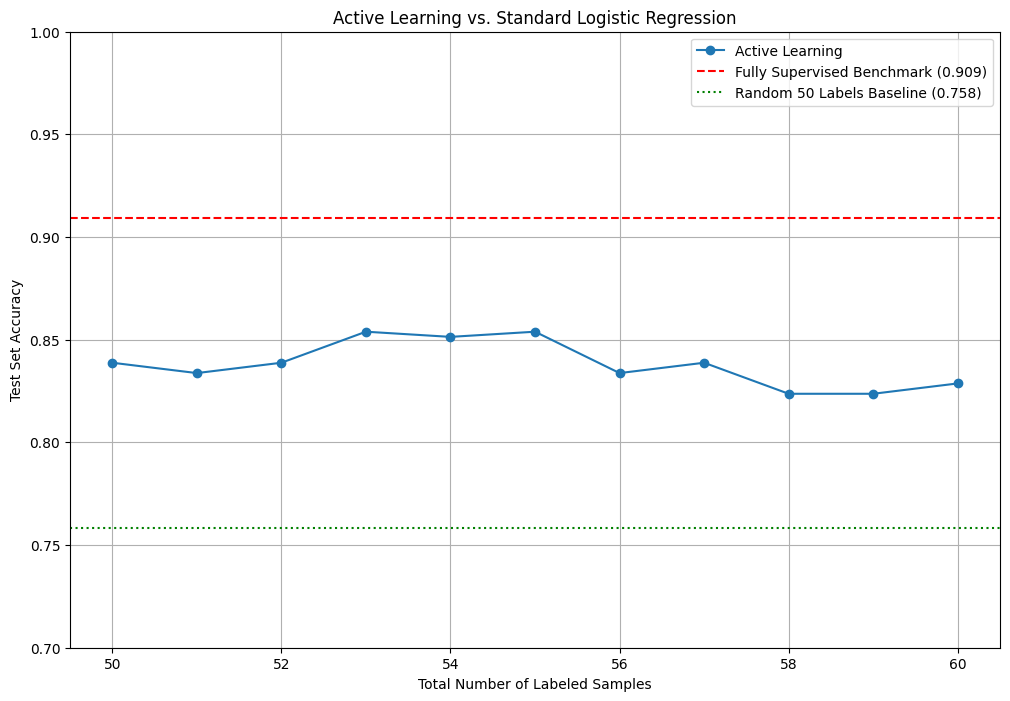

In [8]:
# 1. SETUP AND IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# 2. LOAD DATA AND CREATE SPLITS
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]
n_labeled = 50 # The number of initial labels we will use

# 3. ESTABLISH PERFORMANCE BENCHMARKS
print("--- Establishing Performance Benchmarks ---")

# Benchmark 1: Fully supervised model on the whole training set (our "gold standard")
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
full_accuracy = log_reg_full.score(X_test, y_test)
print(f"Accuracy with full training set (1400 labels): {full_accuracy:.4f}")

# Benchmark 2: Model with only 50 randomly chosen labels (our "naive baseline")
log_reg_random = LogisticRegression(max_iter=10_000)
log_reg_random.fit(X_train[:n_labeled], y_train[:n_labeled])
random_accuracy = log_reg_random.score(X_test, y_test)
print(f"Accuracy with {n_labeled} random labels: {random_accuracy:.4f}\n")


# 4. SEMI-SUPERVISED LEARNING WITH CLUSTERING AND LABEL PROPAGATION
print("--- Method 1: Semi-Supervised Learning via Label Propagation ---")

# Use K-Means to find 50 "representative" samples, one from each cluster's center.
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

# Manually label these 50 representative images (labels from previous step)
y_representative_digits = np.array([
    8, 4, 9, 6, 7, 5, 3, 0, 1, 2, 3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
    5, 6, 5, 7, 3, 1, 0, 8, 4, 7, 1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
    4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

# Train a model on just the 50 representative samples
log_reg_representative = LogisticRegression(max_iter=10_000)
log_reg_representative.fit(X_representative_digits, y_representative_digits)
representative_score = log_reg_representative.score(X_test, y_test)
print(f"Accuracy with {n_labeled} representative labels: {representative_score:.4f}")

# Propagate the representative labels to all other instances in their respective clusters.
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg_propagated = LogisticRegression(max_iter=10_000)
log_reg_propagated.fit(X_train, y_train_propagated)
print(f"Accuracy after propagating labels to all 1400 samples: {log_reg_propagated.score(X_test, y_test):.4f}\n")


# 5. ACTIVE LEARNING
print(f"--- Method 2: Active Learning ---")
print(f"Starting with {n_labeled} representative labels and intelligently querying for more.")

# This is an alternative to label propagation. Instead of guessing labels,
# we intelligently ask for the labels of the most uncertain samples.

# Setup the pool: start with the 50 representative labels.
X_pool = X_train.copy()
y_pool = np.full(len(X_pool), -1, dtype=int)  # -1 for "unknown"
labeled_mask = np.zeros(len(X_pool), dtype=bool)
labeled_mask[representative_digit_idx] = True
y_pool[representative_digit_idx] = y_representative_digits

# Store scores and queried images as we add more labels
test_scores = [representative_score]
n_labeled_axis = [n_labeled]
queried_images = []
queried_labels = []
n_queries = 10 # Let's ask for 10 new labels

for i in range(n_queries):
    # a) Train on currently labeled points
    X_train_AL, y_train_AL = X_pool[labeled_mask], y_pool[labeled_mask]
    model = LogisticRegression(max_iter=10_000)
    model.fit(X_train_AL, y_train_AL)

    # b) Find the most uncertain unlabeled sample (lowest max probability)
    unlabeled_idx = np.where(~labeled_mask)[0]
    probs = model.predict_proba(X_pool[unlabeled_idx])
    uncertainty = 1 - np.max(probs, axis=1)
    query_pos = np.argmax(uncertainty)
    query_idx = unlabeled_idx[query_pos]

    # c) "Query the oracle" for the true label and add it to the pool
    true_label = y_train[query_idx]
    labeled_mask[query_idx] = True
    y_pool[query_idx] = true_label

    # Store the image and its label for visualization
    queried_images.append(X_pool[query_idx])
    queried_labels.append(true_label)

    # d) Retrain with the new label and evaluate
    X_train_AL_new, y_train_AL_new = X_pool[labeled_mask], y_pool[labeled_mask]
    model.fit(X_train_AL_new, y_train_AL_new)
    acc = model.score(X_test, y_test)
    test_scores.append(acc)
    n_labeled_axis.append(len(y_train_AL_new))
    print(f"Query {i+1:2d} | Added label for index {query_idx:4d} | New Accuracy: {acc:.4f}")

# 6. VISUALIZE THE RESULTS

# First, show the images that were queried during active learning
plt.figure(figsize=(12, 3))
for i in range(n_queries):
    plt.subplot(1, n_queries, i + 1)
    plt.imshow(queried_images[i].reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.title(f"Query {i+1}\nTrue Label: {queried_labels[i]}")
    plt.axis('off')
plt.suptitle("Images Selected by Active Learning", fontsize=16)
plt.show()


# Second, plot the final comparison of accuracy vs. number of labels
plt.figure(figsize=(12, 8))
plt.plot(n_labeled_axis, test_scores, "o-", label="Active Learning")
plt.axhline(y=full_accuracy, color='r', linestyle='--', label=f"Fully Supervised Benchmark ({full_accuracy:.3f})")
plt.axhline(y=random_accuracy, color='g', linestyle=':', label=f"Random {n_labeled} Labels Baseline ({random_accuracy:.3f})")

plt.xlabel("Total Number of Labeled Samples")
plt.ylabel("Test Set Accuracy")
plt.title("Active Learning vs. Standard Logistic Regression")
plt.legend()
plt.grid(True)
plt.ylim(0.7, 1.0) # Zoom in on the relevant accuracy range
plt.show()